# Chatbot

In [6]:
from dotenv import load_dotenv
from typing import TypedDict,Annotated,Literal,List,Dict,Any

from langgraph.graph import StateGraph,START,END
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from langgraph.graph.message import add_messages
from langchain_core.documents import Document
import json

from sentence_transformers import SentenceTransformer
import numpy as np
import chromadb

In [4]:
import os
import json

# Setup folder
DOCS_FOLDER = "../policy_documents"
os.makedirs(DOCS_FOLDER, exist_ok=True)

# Dummy policies
policies = {
    "refund_policy.txt": "Refund Policy: Customers can request a refund within 30 days of purchase. The item must be in original packaging. Refunds take 5-10 business days to process.",
    "shipping_policy.txt": "Shipping Policy: We ship globally. Standard shipping takes 3-5 days. Express shipping takes 1-2 days. Free shipping on orders over $50.",
    "cancellation_policy.txt": "Cancellation Policy: Orders can be cancelled within 2 hours of placement. After 2 hours, the order enters processing and cannot be stopped."
}

for filename, content in policies.items():
    with open(os.path.join(DOCS_FOLDER,filename),'w') as f:
        f.write(content)

In [ ]:
# initializing gemini model
load_dotenv()
llm = init_chat_model('google_genai:gemini-2.0-flash')

False

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import time

def load_and_split_data(DOCS_FOLDER: str) -> list:
    """
    Loads text files and chunks them using a Context-Aware Strategy:
    1. Tries to split by Numbered Headers (e.g., "1. POLICY") and injects context.
    2. Falls back to Recursive Splitting if no headers are found.
    """
    
    final_chunks = []
    
    # Fallback splitter for unstructured files
    fallback_splitter = RecursiveCharacterTextSplitter(
        chunk_size=400,
        chunk_overlap=50,
        separators=["\n\n", "\n", ". ", " ", ""]
    )

    for filename in os.listdir(DOCS_FOLDER):
        if not filename.endswith(".txt"):
            continue

        file_path = os.path.join(DOCS_FOLDER, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue

        # Context-Aware Splitting (Secion Numbers)
        # Regex looks for "\n1. " to capture the header.
        sections = re.split(r'\n(\d+\.\s.*)', content)
        
        doc_chunks = []
        policy_category = filename.replace("_", " ").replace(".txt", "").title()
        document_title = content.split('\n')[0].strip() # Assume first line is title
        
        # If regex found sections (Length > 1 means split was successful)
        if len(sections) > 1:
            # sections[0] is usually intro text, skip it or treat as intro
            # Loop starts from 1 and steps by 2 because regex split keeps delimiters
            for i in range(1, len(sections), 2):
                header = sections[i].strip()       # e.g. "1. REFUND PROCESS"
                body = sections[i+1].strip() if i+1 < len(sections) else ""
                
                enriched_text = (
                    f"Section: {header}\n"
                    f"Content: {body}"
                )
                
                doc = Document(
                    page_content=enriched_text,
                    metadata={
                        "policy_type": policy_category,
                        "file_source": filename,
                        "section_header": header,
                        "chunk_id": i // 2, # simple counter
                        "strategy": "header_injection",
                        "last_updated": time.ctime(os.path.getmtime(file_path))
                    }
                )
                doc_chunks.append(doc)
                
    return doc_chunks

In [10]:
import os
import re
data = load_and_split_data('../policy_documents')

In [11]:
list(c.page_content for c in data)

['Document: ROYAL ENFIELD BULLET 650 - REFUND AND BOOKING CANCELLATION POLICY\nSection: 1. VEHICLE BOOKING REFUNDS:\nContent: - Pre-order/Booking Amount: If you have placed a formal booking for the Bullet 650 and wish to cancel before the invoice is generated, you are eligible for a refund.\n- Processing Fee: A nominal cancellation charge (as per regional dealership norms, typically ₹500 - ₹1,000) may be deducted from the booking amount.\n- Refund Timeline: Once the cancellation is confirmed, the balance will be credited to your original payment source within 7–10 working days.',
 'Document: ROYAL ENFIELD BULLET 650 - REFUND AND BOOKING CANCELLATION POLICY\nSection: 2. TEST DRIVES:\nContent: - Test drives are complimentary. No charges are collected, and therefore, no refunds are applicable for test drive appointments.',
 'Document: ROYAL ENFIELD BULLET 650 - REFUND AND BOOKING CANCELLATION POLICY\nSection: 3. ACCESSORIES & APPAREL:\nContent: - Return Window: Genuine Royal Enfield acces

In [31]:
class EmbeddingManager:
    """Handles document embedding generation using SentenceTransformer"""

    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        """
        Initialize the embedding manager

        Args:
            model_name: HuggingFace model name for sentence embeddings
        """
        self.model_name = model_name
        self.model = None
        self._load_model()

    def _load_model(self):
        """Load the SentenceTransformer model"""
        try:
            print(f"Loading embedding model: {self.model_name}")
            self.model = SentenceTransformer(self.model_name)
            print(f"Model loaded successfully. Embedding dimension: {self.model.get_sentence_embedding_dimension()}")
        except Exception as e:
            print(f"Error loading model {self.model_name}: {e}")
            raise

    def generate_embeddings(self, texts: List[str]) -> np.ndarray: #<----------------------------
        
        if not self.model:
            raise ValueError("Model not loaded")

        # print(f"Generating embeddings for {len(texts)} texts...")
        embeddings = self.model.encode(texts)
        # print(f"Generated embeddings with shape: {embeddings.shape}")
        return embeddings

embedding_manager = EmbeddingManager()
embedding_manager

Loading embedding model: all-MiniLM-L6-v2
Model loaded successfully. Embedding dimension: 384


In [32]:
client = chromadb.PersistentClient(path = VECTOR_DB_PATH)

docs = load_and_split_data('./knowledgeBase.json')
embeddings = embedding_manager.generate_embeddings([doc.page_content for doc in docs])

db = client.get_or_create_collection(
    name='AutoStream',
    metadata={'description':'Pricing & Policies on AutoStream'}
)



ids = []
metadatas = []
documents_text = []
embeddings_list = []

for i, (doc, embedding) in enumerate(zip(docs, embeddings)):
    # Generate unique ID
    doc_id = str(1000+i)
    ids.append(doc_id)

    # Prepare metadata
    metadata = dict(doc.metadata)
    metadata['doc_index'] = i
    metadata['content_length'] = len(doc.page_content)
    metadatas.append(metadata)

    # Document content
    documents_text.append(doc.page_content)

    # Embedding
    embeddings_list.append(embedding.tolist())

# Add to collection
try:
    db.add(
        ids=ids,
        embeddings=embeddings_list,
        metadatas=metadatas,
        documents=documents_text
    )
    print(f"Successfully added {len(docs)} documents to vector store")
    print(f"Total documents in collection: {db.count()}")

except Exception as e:
    print(f"Error adding documents to vector store: {e}")
    raise

Successfully added 4 documents to vector store
Total documents in collection: 4


In [38]:
class RAGRetriever:
    """Handles query-based retrieval from the vector store"""

    def __init__(self, vector_store, embedding_manager):
        """
        Initialize the retriever

        Args:
            vector_store: Vector store containing document embeddings
            embedding_manager: Manager for generating query embeddings
        """
        self.vector_store = vector_store
        self.embedding_manager = embedding_manager

    def retrieve(self, query: str, top_k: int = 2) -> List[Dict[str, Any]]:
        
        # print(f"Retrieving documents for query: '{query}'")

        # Generate query embedding
        query_embedding = self.embedding_manager.generate_embeddings([query])[0]

        # Search in vector store
        try:
            results = self.vector_store.query(
                query_embeddings=[query_embedding.tolist()],
                n_results=top_k
            )

            if (len(results['ids']) == 0):
                print("No documents found")

            return results

        except Exception as e:
            print(f"Error during retrieval: {e}")
            return []

rag_retriever=RAGRetriever(db,embedding_manager)

In [39]:
# Declaring the State
class State(TypedDict):
    messages:Annotated[list,add_messages]
    user_intent:Literal['lead','inquiry','greeting','extract details']
    user_data:dict

def get_chat_history(state:State):
    history = ['human: '+s.content if type(s)==HumanMessage else 'bot: '+s.content for s in state['messages'] ]
    return history

def route_based_on_intent(state: State):
    # This function reads the state we just updated
    intent = state['user_intent']
    if intent.content.lower().strip() == 'high-intent lead':
        intent = 'lead'
    elif intent.content.lower().strip() == 'product or pricing inquiry':
        intent = 'inquiry'
    elif intent.content.lower().strip() == 'extract lead details':
        intent = 'extract details'
    else:
        intent = 'greeting'
    return intent

def classify_user_enquiry_type(state:State) -> State:
    
    # retrieving past n messages by the user to find out the user intent
    # user_chat = state['messages']
    chat_history = str(get_chat_history(state))
    
    prompt = [ SystemMessage("""
                    You are an intent classification agent:
                    1. Casual greeting
                    2. Product or pricing inquiry
                    3. High-intent lead
                    4. Extract lead details

                    CRITICAL OUTPUT RULES:
                    - Output ONLY the category name. 
                """),
              
              HumanMessage(chat_history)
            ]
    
    intent = llm.invoke(prompt)

    return {'user_intent': intent}

def reply_to_casual_greeting(state:State) -> State:
    
    # user_chat = state['messages'][-1].content
    chat_history = str(get_chat_history(state))
    
    
    prompt = [
        SystemMessage("""
                    You are the Sales & Onboarding Specialist for **AutoStream**, a SaaS platform that automates video editing for creators.

                    **Your Goal:**
                    Secure a user sign-up. However, if the user seems unsure, your secondary goal is to educate them to build trust.

                    **Instructions for Handling Greetings:**
                    When a user sends a greeting (e.g., "Hi", "Hello"):
                    1.  **Warm Welcome:** Greet them professionally and enthusiastically.
                    2.  **Value Hook:** Briefly mention that AutoStream saves creators hours of editing time.
                    3.  Invite them sign up to create a free account to test it out by asking them to provide their details.
                    4.  Make the response one line.

                    **Tone:**
                    Helpful, knowledgeable, and inviting.

                    """),
        HumanMessage(chat_history)
    ]    
    state = {'messages':[llm.invoke(prompt)]}
    
    return state

import json
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

from langchain_core.messages import SystemMessage, HumanMessage

def ask_user_for_lead_information(state: State):
    
    chat_history = str(get_chat_history(state))
    
    prompt = [
        SystemMessage(f"""
            You are the **AutoStream Sign-Up Assistant**.
            
            **Goal:** Ask the user to provide their registration details to sign up.
            
            **Required Details:**
            1. Name
            2. Email (or Contact Number)
            3. Creator Platform (e.g., YouTube, Instagram, TikTok)
            
            **Instructions:**
            - Check the chat history below.
            - If NO details are present, ask for all three in one friendly, energetic sentence.
            - If SOME details are present (e.g., user already said "I'm John"), ask ONLY for the missing details.
            - Keep it brief and conversational.
        """),
        HumanMessage(chat_history)
    ]
    
    response = llm.invoke(prompt)
    
    return {'messages': [response]}


def extract_lead_data(state: State) -> dict:
    
    chat_history = str(get_chat_history(state))
    
    prompt = [
        SystemMessage("""
            You are the Data Extraction Engine for AutoStream.
            Your Goal: Analyze the chat history and extract user details into JSON.
            
            Extraction Rules:
            - Name: Full name or null
            - Contact: Email/Phone or null
            - Platform: Content platform or null
            
            Output Format: ONLY JSON. No text.
            Example: {"name": "John", "contact": null, "platform": "YouTube"}
        """),
        HumanMessage(content=chat_history)
    ] 
    
    # 3. Invoke LLM & Parse
    response = llm.invoke(prompt).content
    cleaned_json = response.replace('```json', '').replace('```', '').strip()
    
    try:
        lead_data = json.loads(cleaned_json)
    except json.JSONDecodeError:
        lead_data = {"name": None, "contact": None, "platform": None}

    # Check if ALL values are present
    if all(lead_data.values()):
        # All fields have data -> Success
        success_msg = AIMessage(content='Successfully signed-up! Welcome to AutoStream.')
    else:
        # Something is missing -> Identify what is missing
        missing_fields = [key for key, value in lead_data.items() if not value]
        success_msg = AIMessage(content=f"Could you please provide your {', '.join(missing_fields)} to complete the signup?")
        
    return {
        'messages': [success_msg], 
        'user_data': lead_data
    }

def reply_to_enquiry(state:State)->State:
    
    query_topic = get_chat_history(state)[-1]
    context = rag_retriever.retrieve(query_topic)
    
    chat_history = str(get_chat_history(state))
    
    prompt = [
        SystemMessage(f"""
                You are the **AutoStream Sales AI**.

                **Goal:** Answer accurately using the Context provided, while persuading the user to sign up (user should say yes to signup).

                **Instructions:**
                1. **Source of Truth:** Use ONLY the provided Context.
                2. **IF THE CONTEXT IS NOT PROVIDED**: respond that you don't have the specific details on that right now, and tell them the known things.
                3. **Sell the Benefit:** Don't just list specs. Explain *why* the feature helps them (e.g., "4K makes your content look professional").
                4. **Closing:** Always end with a brief Call to Action (e.g., "Ready to try it out?").
                
                CONTEXT:
                {context}
                """),
        HumanMessage(chat_history)
    ]
    
    state = {'messages':[llm.invoke(prompt)]}
    return state

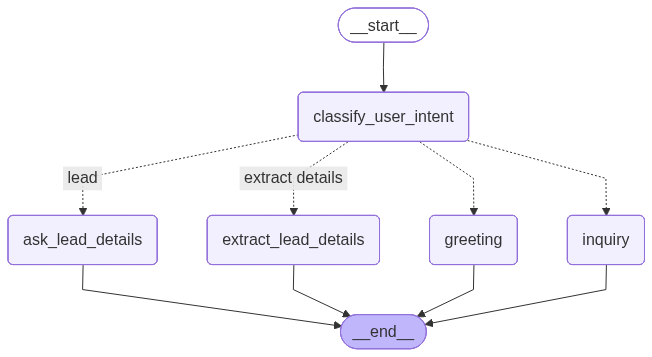

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

builder = StateGraph(State)

builder.add_node('classify_user_intent',classify_user_enquiry_type)
builder.add_node('greeting',reply_to_casual_greeting)
builder.add_node('inquiry',reply_to_enquiry)
builder.add_node('ask_lead_details',ask_user_for_lead_information)
builder.add_node('extract_lead_details',extract_lead_data)

builder.add_edge(START,'classify_user_intent')
builder.add_conditional_edges(
    'classify_user_intent',
    route_based_on_intent,
    {
        'lead':'ask_lead_details',
        'inquiry':'inquiry',
        'greeting':'greeting',
        'extract details':'extract_lead_details'
    }
)

builder.add_edge(['inquiry','greeting','ask_lead_details','extract_lead_details'],END)


# graph = builder.compile()
graph = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}



from IPython.display import Image, display
png_bytes = graph.get_graph().draw_mermaid_png()
# Save to file
with open("graph.png", "wb") as f:
    f.write(png_bytes)

# Still display in notebook
display(Image(png_bytes))


In [ ]:
state = None

while True:
    query = input('You : ')
    print('You : ',query)
    
    if query.strip().lower() in ['exit','q','quit']:
        break
    
    state = {'messages':[HumanMessage(query)]}
    
    state = graph.invoke(state,config=config)
    
    # Exit if data is captured
    lead_data = state.get('user_data',{})
    if lead_data and all(lead_data.values()):
        break
    
    print('Bot : ',state['messages'][-1].content)

You :  hi there
Bot :  Hi there! AutoStream saves creators hours on editing, would you like to sign up for a free account to test it out?
You :  whats the expensive plan
Bot :  The Pro Plan is our top-tier option at $79/month. You'll get stunning 4K resolution, making your content look incredibly professional. Plus, you can upload an unlimited number of videos! And if you ever need help, you'll have access to our 24/7 priority support.

Ready to try it out?
You :  whats its resolution
Bot :  The Pro Plan offers 4K resolution. This will make your content look incredibly professional and polished, helping you stand out from the crowd.

Ready to sign up?
You :  whats its price
Bot :  The Pro Plan is priced at $79 per month. For that, you get 4K resolution, unlimited video uploads, and 24/7 priority support!

Ready to sign up?
You :  whats the max uplode rate
Bot :  With the Pro Plan, you get unlimited video uploads! Never worry about hitting a limit again.

Ready to sign up?
You :  what p

In [56]:
state['messages'][-6:]

[HumanMessage(content='whats the max uplode rate', additional_kwargs={}, response_metadata={}, id='cebcd93a-7f2d-4af3-9242-1ce6c995ecfb'),
 AIMessage(content='With the Pro Plan, you get unlimited video uploads! Never worry about hitting a limit again.\n\nReady to sign up?', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bb666-b49c-7f53-ba48-d58d0a3819a3-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 643, 'output_tokens': 26, 'total_tokens': 669, 'input_token_details': {'cache_read': 0}}),
 HumanMessage(content='what plan did i asked for', additional_kwargs={}, response_metadata={}, id='dcb8ea59-787e-45a9-88e6-036a7a89dfed'),
 AIMessage(content="I don't have the specific details on what you asked for, but I can tell you about our plans! We have a Basic plan at $29/month and a Pro plan at $79/month. Ready to sign up?", additional_kwargs={